#0)Conexion a Drive remoto

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/My Drive/tfm"

chi_sim_vert.traineddata     encoder_inf_model_v3_1.h5	  model_weights_v3_1.h5
chi_tra_vert.traineddata     encoder_inf_weights_v2_1.h5  model_weights_v3.h5
dataset_en_2.txt	     encoder_inf_weights_v3_1.h5  ted_dev_en.txt
dataset_en.txt		     es.bin			  ted_dev_zh1.txt
dataset_es.txt		     es.bin.syn0.npy		  ted_test1_en.txt
dataset_zh.txt		     es.bin.syn1neg.npy		  ted_test1_zh.txt
decoder_inf_model_v2_1.h5    img_prueba.png		  ted_train_en.txt
decoder_inf_model_v2.png     manythings_en_es.txt	  ted_train_zh.txt
decoder_inf_model_v3_1.h5    manythings_en_zh.txt	  zh.bin
decoder_inf_weights_v2_1.h5  model_2_1.png		  zh.bin.syn0.npy
decoder_inf_weights_v3_1.h5  model_complete_v3_1.h5	  zh.bin.syn1neg.npy
en.bin			     model_complete_v3.h5
encoder_inf_model_v2_1.h5    model_weights_v2_1.h5


#1) Creacion de datasets

hanziconv: Ayuda a transformar entre caracteres chinos y tradicionales

https://pypi.org/project/hanziconv/0.3/

jieba: Herramienta que ayuda a la tokenizacion, separando los caracteres chinos por palabras

https://github.com/fxsjy/jieba

In [ ]:
pip install hanziconv

     |████████████████████████████████| 286kB 2.8MB/s 
  Created wheel for hanziconv: filename=hanziconv-0.3.2-py2.py3-none-any.whl size=23215 sha256=216f8e2b2a0bd44d95aedbd0a5326f4a7c2d1255faf5ece2e351b87f52d7939a
  Stored in directory: /root/.cache/pip/wheels/03/d8/3c/c39898fa9c9ce6e34b0ab4c6604892462d440c743715c94054
Successfully built hanziconv


In [ ]:
pip install jieba

In [ ]:
import re
import unicodedata
import io
import jieba
from hanziconv import HanziConv
import string

##1.1 abrir archivo

In [ ]:
#Funcion abrir archivos y guardarlos en variable
def open_txt(dataset):
    texto = open(dataset, mode="r", encoding="utf-8")
    datos = texto.read()
    texto.close
    return datos

In [ ]:
path = "/content/gdrive/My Drive/tfm/manythings_en_zh.txt"
path_base = "/content/gdrive/My Drive/tfm/"

##1.2 unicode to ascii

In [ ]:
#Funcion de limpieza: Convertir a ASCII, eliminar acentos, pasar a minuscula 
def unicode_to_ascii(texto):
    return ''.join(c for c in unicodedata.normalize('NFD', texto)
      if unicodedata.category(c) != 'Mn')

##1.3 Preprocesado de texto

In [ ]:
def preprocessing_zh(texto):
    t = unicode_to_ascii(texto.lower().strip())#strip()quita espacios blancos de delante y atras
    #añadir un espacio entre las palabras y los simbolos de puntuacion
    t = re.sub(r"[^?.!,¿,。！？\u4e00-\u9fff]+", " ", t)#deberia ir primero?
    t = re.sub(r"([?.!,¿])", r" \1 ", t)
    t = re.sub(r'[" "]+', " ", t)
    t = t.strip()
    t = t.lstrip(".") #cuanto quitamos numeros de puntos del dia queda un punto suelto raro
    t = t.lstrip(",")
    t = jieba.cut(t, cut_all=False) #jieba, herramienta para dividir la frase en palabras y añadir espacios entre ellas
    t = " ".join(t)
    t = HanziConv.toTraditional(t)
    return t


In [ ]:
def preprocessing_es(texto):
    t = unicode_to_ascii(texto.lower().strip()) #strip()quita espacios blancos de delante y atras
    #añadir un espacio entre las palabras y los simbolos de puntuacion
    t = re.sub(r"([?.!,¿])", r" \1 ", t)
    t = re.sub(r'[" "]+', " ", t)
    #t = re.sub(r'\w*\d\w*', '', texto) #Elimina el pinyin
    # reemplazar todo con espacio excepto y characteres chinos (a-z, A-Z, ".", "?", "!", ",")
    t = re.sub(r"[^a-zA-Z0-9?.!,¿]+", " ", t) #Mal, hay que conservar la puntuacion
    t = t.strip()
    t = re.sub(r'\w*\d\w*', '', t) #Elimina el pinyin de tatoeba pairs
    t = t.lstrip(".") #cuanto quitamos numeros de puntos del dia queda un punto suelto raro
    t = t.lstrip(",")
    t = re.sub(r'^.*?\\.',"",t)
    t = "<start> "+ t + " <end>"  
    return t

In [ ]:
zh = ", 我会借这本特别好的书吗。hola que tal"
print(preprocessing_zh(zh))

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.811 seconds.
Prefix dict has been built successfully.


  我會 藉 這本 特彆 好 的 書 嗎 。


In [ ]:
zh_sentence = "我会借这本书?"
sp_sentence = "¿Can I borrow this book??"
print(preprocessing_zh(zh_sentence))
print(preprocessing_es(sp_sentence))

我會 藉 這 本書   ?
<start> ¿ can i borrow this book ? ? <end>


##1.4 Combinar en un dataset

In [ ]:
#Datasets independientes
def create_dataset_ind(path, language="es"):
    lines = io.open(path, encoding="UTF-8").read().strip().split("\n")
    text = [l.split("\t",2)[0:2] for l in lines]

    if language == "zh":
        dataset = [preprocessing_zh(text[t][1]) for t in range(len(text))]
    
    else:
        dataset = [preprocessing_es(text[t][0]) for t in range(len(text))]

    return dataset

In [ ]:
dataset_zh = create_dataset_ind(path, language="zh")
dataset_en = create_dataset_ind(path)

##1.5 Guardar el dataset

In [ ]:
def save_dataset(data, filename="dataset"):
    with open(path_base + filename + ".txt", mode='wt', encoding='utf-8') as myfile:
        myfile.write('\n'.join(str(data[i]) for i in range(1,len(data))))

In [ ]:
dataset_zh = save_dataset(dataset_zh, "dataset_zh")
dataset_en = save_dataset(dataset_en, "dataset_en")

#2)Modelo, encoder-decoder, GRU, bidireccional, con atencion

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/My Drive/tfm"

 Atencion_modificada_TFM_machine_translation_v3_2.ipynb
 chi_sim_vert.traineddata
 chi_tra_vert.traineddata
 dataset_en_2.txt
 dataset_en.txt
 dataset_es.txt
 dataset_zh.txt
 decoder_inf_model_v2_1.h5
 decoder_inf_model_v2.png
 decoder_inf_model_v3_1.h5
 decoder_inf_weights_v2_1.h5
 decoder_inf_weights_v3_1.h5
 en.bin
 encoder_inf_model_v2_1.h5
 encoder_inf_model_v3_1.h5
 encoder_inf_weights_v2_1.h5
 encoder_inf_weights_v3_1.h5
 es.bin
 es.bin.syn0.npy
 es.bin.syn1neg.npy
 img_prueba.png
 manythings_en_es.txt
 manythings_en_zh.txt
 model_2_1.png
 model_complete_v3_1.h5
 model_complete_v3.h5
 model_weights_v2_1.h5
 model_weights_v3_1.h5
 model_weights_v3.h5
 ted_dev_en.txt
 ted_dev_zh1.txt
 ted_test1_en.txt
 ted_test1_zh.txt
 ted_train_en.txt
 ted_train_zh.txt
'Trabajo Fin de Master.docx'
 zh.bin
 zh.bin.syn0.npy
 zh.bin.syn1neg.npy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import io
from tensorflow.keras import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, GRU, Input, Dense, TimeDistributed, AdditiveAttention,Embedding, Bidirectional, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import Word2Vec, KeyedVectors
from nltk.translate.bleu_score import corpus_bleu

##2.1 Preparación de datos

Importar datos, tokenizacion, obtencion de parametros (Longitud maxima de la secuencia, vocabulario maximo de cada idioma)

In [ ]:
def open_data(dataset, num_examples=None):
    with open(dataset) as archivo:
        datos = [line.rstrip('\n') for line in archivo]
        corpus = datos[:num_examples]
        
    return corpus

In [ ]:
def tokenizer(dataset, max_len, max_features, language="en"):
 
   
    tokenizer_lang = Tokenizer(num_words=max_features, filters="")
    
    tokenizer_lang.fit_on_texts(dataset) 
#asignamos un numero a cada palabra, es como un diccionario int-string
#Las palabras mas frecuentes tienen numeros mas bajos, 0 queda reservado a padding

    word_tensor = tokenizer_lang.texts_to_sequences(dataset) 
    word_tensor = tf.keras.preprocessing.sequence.pad_sequences(word_tensor,\
                                                               maxlen=max_len,\
                                                               padding = "post")
    return tokenizer_lang, word_tensor


In [ ]:
#Corpus
num_examples = 20000
corpus_zh = open_data("/content/gdrive/My Drive/tfm/dataset_zh.txt", num_examples=num_examples)
corpus_en = open_data("/content/gdrive/My Drive/tfm/dataset_en.txt", num_examples=num_examples)

In [ ]:
print(corpus_zh[0:100])

['你好 。', '你 用 跑 的 。', '等等 ！', '等 一下 ！', '你好 。', '我 贏 瞭 。', '不會 吧 。', '乾杯   !', '你 懂 瞭 嗎 ？', '他 跑 瞭 。', '跳進來 。', '我 退齣 。', '我 沒事 。', '我 已經 起來 瞭 。', '聽 著 。', '不 可能 ！', '沒門 ！', '你 確定 ？', '試試 吧 。', '我們 來 試試 。', '為什麼 是 我 ？', '去 問 湯姆 。', '好棒 ！', '冷靜 點 。', '公平 點 。', '友善 點 。', '和 氣點 。', '友善 點 。', '聯係 我 。', '聯係 我們 。', '進來 。', '找到 湯姆 。', '滾 齣去 ！', '齣去 ！', '走開 ！', '滾 ！', '走開 ！', '迴傢吧 。', '再見 ！', '告辭 ！', '堅持 。', '等 一下 ！', '堅持 。', '他來 瞭 。', '他 跑 。', '幫 我 一下 。', '幫幫 我們 吧 ！', '去 打 湯姆 。', '堅持 。', '抱抱 湯姆 ！', '請 抱緊 湯姆 。', '我 同意 。', '我 生病 瞭 。', '我 老 瞭 。', '我 濕 瞭 。', '沒關係 。', '是 我 。', '來 加入 我們 吧 。', '留著 吧 。', '吻 我 。', '完美 ！', '再見 ！', '閉嘴 ！', '不管 它 。', '拿走 吧 。', '醒醒 ！', '去 清洗 一下 。', '我們 知道 。', '歡迎 。', '誰 贏 瞭 ？', '為什麼 不 ？', '你 跑 。', '算你狠 。', '往 後退 點 。', '靜靜的   彆動 。', '我 一無所知 。', '把 他 銬 上 。', '往前 開 。', '走開 ！', '滾 ！', '趴下 ！', '滾 ！', '滾 。', '滾 。', '醒醒 吧 。', '做得好 ！', '乾 的 好 ！', '抓住 湯姆 。', '抓住 他 。', '玩得 開心 。', '他來 試試 。', '多 可愛 啊 ！', '你 就 隨 瞭 我 的 意 吧 。', '趕快   !', '快點 ！', '快點 。', '我 做到 瞭 ！', '我 忘 瞭 。', '我 放棄 。', 

In [ ]:
print(corpus_en[0:100])

['<start> hi . <end>', '<start> run . <end>', '<start> wait ! <end>', '<start> wait ! <end>', '<start> hello ! <end>', '<start> i won ! <end>', '<start> oh no ! <end>', '<start> cheers ! <end>', '<start> got it ? <end>', '<start> he ran . <end>', '<start> hop in . <end>', '<start> i quit . <end>', '<start> i m ok . <end>', '<start> i m up . <end>', '<start> listen . <end>', '<start> no way ! <end>', '<start> no way ! <end>', '<start> really ? <end>', '<start> try it . <end>', '<start> we try . <end>', '<start> why me ? <end>', '<start> ask tom . <end>', '<start> awesome ! <end>', '<start> be calm . <end>', '<start> be fair . <end>', '<start> be kind . <end>', '<start> be nice . <end>', '<start> be nice . <end>', '<start> call me . <end>', '<start> call us . <end>', '<start> come in . <end>', '<start> get tom . <end>', '<start> get out ! <end>', '<start> get out ! <end>', '<start> go away ! <end>', '<start> go away ! <end>', '<start> go away . <end>', '<start> go home . <end>', '<start>

In [ ]:
def max_len(datos):
    return max(len(line.split()) for line in datos)

In [ ]:
#Longitud maxima de secuencia
zh_max_len=max_len(corpus_zh)
en_max_len=max_len(corpus_en)
global_max_len = max(en_max_len, zh_max_len)
print(f"max len zh : {zh_max_len}")
print(f"max len es : {en_max_len}")
print(f"max len global : {global_max_len}")


max len zh : 17
max len es : 15
max len global : 17


In [ ]:
#Tokenizacion. Obtenemos tokenizador y el texto codificado con integers
zh_tokenizer_lang, zh_word_tensor = tokenizer(corpus_zh, global_max_len, max_features=3000)
en_tokenizer_lang, en_word_tensor = tokenizer(corpus_en, global_max_len, max_features=3000)

In [ ]:
print(f"zh_word_tensor shape: {zh_word_tensor.shape}, en_word_tensor shape: {en_word_tensor.shape}")

zh_word_tensor shape: (20000, 17), en_word_tensor shape: (20000, 17)


In [ ]:
#Longitud del vocabulario. Se muestran todas pero el modelo solo tiene en cuenta el n-maximo 
#que hemos puesto en Tokenizer
zh_vocab_size = len(zh_tokenizer_lang.word_index)
en_vocab_size = len(en_tokenizer_lang.word_index)
print(zh_vocab_size)
print(en_vocab_size)

10562
5381


In [ ]:
zh_train, zh_test, en_train, en_test = train_test_split(zh_word_tensor, en_word_tensor,\
                                                        test_size=0.1,random_state=13)

##2.2 Preparacion de los archivos de embedding

Fuente de los archivos: https://github.com/Kyubyong/wordvectors

In [ ]:
#Archivos embedding
embedding_file_en = "/content/gdrive/My Drive/tfm/en.bin"
embedding_file_zh = "/content/gdrive/My Drive/tfm/zh.bin"

In [ ]:
def from_w2v_to_dict(embedding_file, lang="zh"):
    if lang == "en":
        model = KeyedVectors.load_word2vec_format(embedding_file, binary=True)
    else:
        model = Word2Vec.load(embedding_file)

    vector = model.wv.vectors
    palabras = model.wv.index2word
    union_embeddings = dict(zip(palabras,vector))
    return union_embeddings

In [ ]:
embedding_zh = from_w2v_to_dict(embedding_file_zh)
embedding_en = from_w2v_to_dict(embedding_file_en, lang="en")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [ ]:
def get_embedding_weights(embedd_dict, tokenizer_index, max_features=1000): 
    embed = list(embedd_dict.values())
    
    all_embs = np.stack(embed)
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1] #probar

    word_index = tokenizer_index.word_index
    nb_words = len(word_index)

    embedding_matrix = np.random.normal(emb_mean, emb_std,\
                                        size=(nb_words, embed_size)) 

    for word, i in word_index.items():
        if i >= max_features: 
            continue
        embedding_vector = np.array(embedd_dict.get(word))
        if embedding_vector.size is not 1: 
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
emb_zh = get_embedding_weights(embedding_zh, zh_tokenizer_lang, max_features=zh_vocab_size)
emb_en = emb = get_embedding_weights(embedding_en, en_tokenizer_lang, max_features=en_vocab_size)

In [ ]:
print(f"emb_zh shape: {emb_zh.shape}, emb_en shape: {emb_en.shape}")

emb_zh shape: (10562, 300), emb_en shape: (5381, 300)


##2.3)Modelo para entrenar (con Teacher Forcing)

###2.3.1 Generador de datos para entrenamiento en batches

In [ ]:
def generate_batch(X, y, global_max_len, vocab_size_out, batch_size):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, global_max_len),dtype='float32')
            decoder_input_data = np.zeros((batch_size, global_max_len),dtype='float32')
            decoder_target_data = np.zeros((batch_size, global_max_len, vocab_size_out),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text):
                    encoder_input_data[i, t] = word # encoder input seq
                for t, word in enumerate(target_text):
                    if t < len(target_text)-1:
                        decoder_input_data[i, t] = word # decoder input seq
                    if t > 0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t-1 , word] = 1 #si el vector es (1, 2, 4) ese 4 es 0001
            yield ([encoder_input_data, decoder_input_data], decoder_target_data)

In [ ]:
#Prueba
b_size= 128
batch = generate_batch(zh_train, en_train, global_max_len, en_vocab_size, b_size)
batch1 = next(batch)
batch2 = next(batch)

In [ ]:
print(f"batch encoder_input shape (batch, global_max_len): {batch1[0][0].shape},\n \
batch decoder_input shape (batch, global_max_len): {batch1[0][1].shape}, \n \
batch decoder output shape (batch, global_max_len, output_num_words): {batch1[1].shape}")

batch encoder_input shape (batch, global_max_len): (128, 17),
 batch decoder_input shape (batch, global_max_len): (128, 17), 
 batch decoder output shape (batch, global_max_len, output_num_words): (128, 17, 5381)


In [ ]:
print(batch1[0][0][0][0])
print(batch1[0][1][0][1])
print(batch1[1][0][0][11])

5.0
46.0
0.0


In [ ]:
#Peso por batch
print(f"{(batch1[1].size/1024)/1024} MB con batch size = {b_size}")

11.1666259765625 MB con batch size = 128


###2.3.2 Modelo Entrenamiento

####2.3.2.1 Capa de Atencion Bahdanau

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

####2.3.2.2 Modelo Seq2seq Encoder-Decoder

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 17, 300)      3168600     input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 17, 2048), ( 8146944     embedding_3[0][0]                
__________________________________________________________________________________________________
states_h (Concatenate)          (None, 2048)         0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][2]      

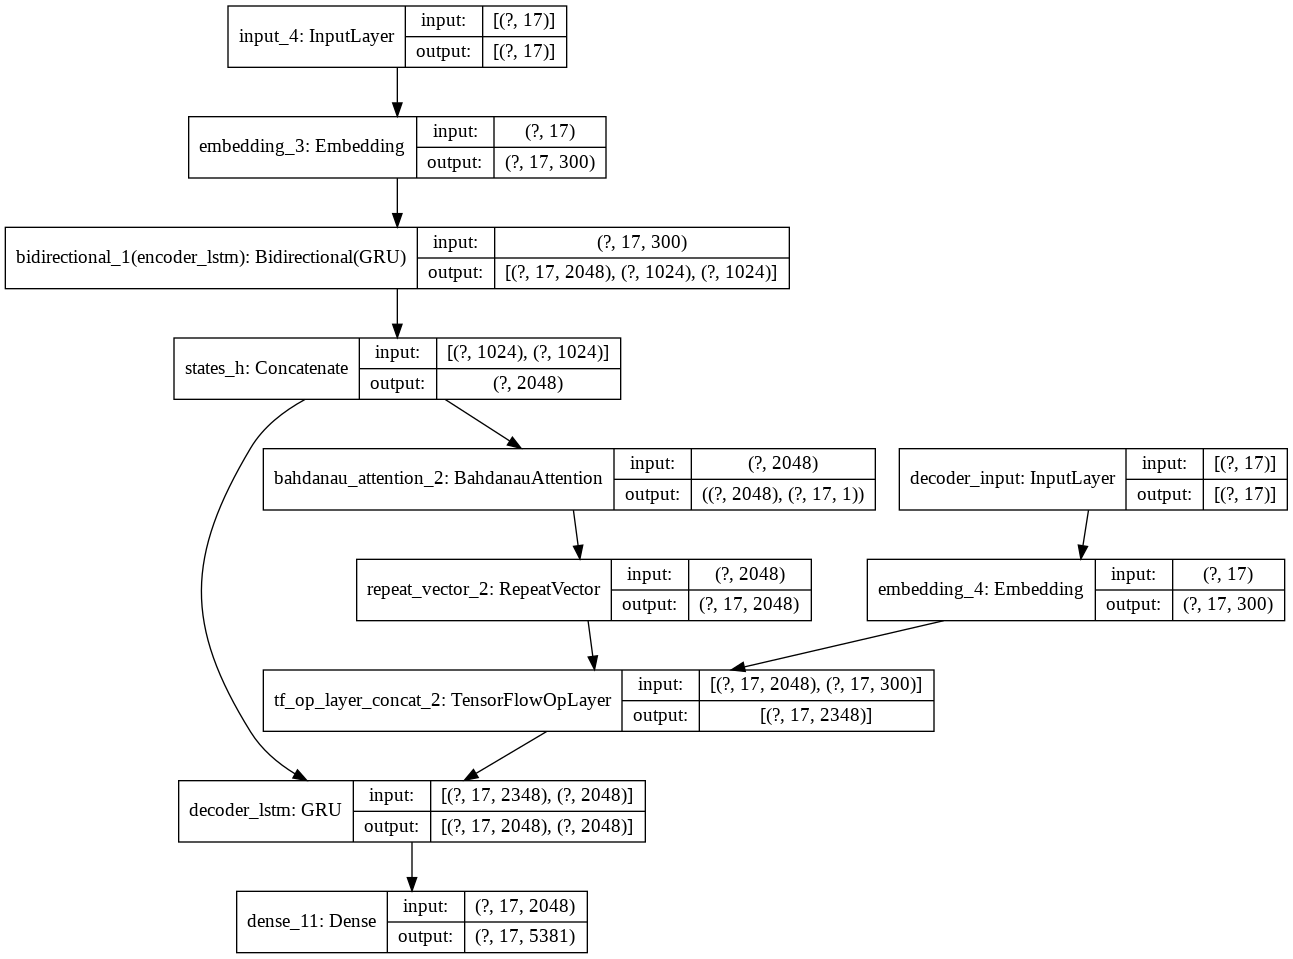

In [ ]:
#training model zh-en
nodes_lstm = 1024
learning_rate = 0.0001
clip_value = 1
dropout=0.1
#encoder-zh
encoder_input = Input(shape=(global_max_len,))
encoder_embedding = Embedding(zh_vocab_size, 300, input_length=global_max_len,
                              mask_zero=True)(encoder_input)
encoder_gru = Bidirectional(GRU(nodes_lstm, return_sequences=True,\
                                unroll=True,dropout=dropout, return_state=True,\
                                name="encoder_lstm"))
encoder_output, state_h_f, state_h_b = encoder_gru(encoder_embedding)
state_h = Concatenate(name="states_h")([state_h_f, state_h_b])


#Attention Layer
attention_layer = BahdanauAttention(nodes_lstm*2)
context_vector, attention_weights = attention_layer(state_h, encoder_output)#output del encoder y decoder
context_vector = tf.keras.layers.RepeatVector(global_max_len)(context_vector)#repeat vector=longitud de secuencia objetivo

#decoder-en
decoder_input = Input(shape=(global_max_len), name="decoder_input")
decoder_emb = Embedding(en_vocab_size, 300, input_length = global_max_len,\
                        mask_zero=True)(decoder_input)

decoder_emb_attention = tf.concat([context_vector, decoder_emb], axis=-1)
   
decoder_gru = GRU(nodes_lstm*2, return_sequences=True, return_state=True,\
                    unroll=True, dropout=dropout, name="decoder_lstm")

decoder_output,_= decoder_gru(decoder_emb_attention, initial_state=state_h)


#Output del decoder
decoder_dense_output = Dense(en_vocab_size, activation="softmax")(decoder_output)

model = Model(inputs=[encoder_input, decoder_input], outputs=[decoder_dense_output])

#compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,\
                                                    clipvalue=clip_value),\
              loss="categorical_crossentropy") 
#Summarize compiled model
model.summary()
plot_model(model, to_file="/content/gdrive/My Drive/tfm/model_2_1.png", show_shapes=True)



####2.3.2.3 fit modelo

In [ ]:
#fit model. hay que poner [encoder input data, decoder input data], target input data=dcoder input data=1 timestep
epochs = 50
b_size = 256
checkpoint = ModelCheckpoint("/content/gdrive/My Drive/tfm/model_weights_v3_1.h5",\
                             monitor="val_loss", verbose=1, save_best_only=True\
                             ,mode="min", save_weights_only=True)
model.fit(generate_batch(zh_train, en_train, global_max_len, en_vocab_size, b_size),\
                    steps_per_epoch=len(zh_train)//b_size,\
                    epochs=epochs,\
                    validation_data=generate_batch(zh_test, en_test, global_max_len, en_vocab_size, b_size),\
                    validation_steps=len(zh_test)//b_size,\
                    verbose=1,\
                    callbacks=[checkpoint],)
#model.save("/content/gdrive/My Drive/tfm/model_complete_v3_1.h5")
#RMSprop bien

Epoch 1/50
70/70 [==============================] - ETA: 0s - loss: 4.7050
Epoch 00001: val_loss improved from inf to 2.95975, saving model to /content/gdrive/My Drive/tfm/model_weights_v3_1.h5
70/70 [==============================] - 72s 1s/step - loss: 4.7050 - val_loss: 2.9598
Epoch 2/50
70/70 [==============================] - ETA: 0s - loss: 2.7063
Epoch 00002: val_loss improved from 2.95975 to 2.51092, saving model to /content/gdrive/My Drive/tfm/model_weights_v3_1.h5
70/70 [==============================] - 70s 1s/step - loss: 2.7063 - val_loss: 2.5109
Epoch 3/50
70/70 [==============================] - ETA: 0s - loss: 2.3191
Epoch 00003: val_loss improved from 2.51092 to 2.29394, saving model to /content/gdrive/My Drive/tfm/model_weights_v3_1.h5
70/70 [==============================] - 70s 998ms/step - loss: 2.3191 - val_loss: 2.2939
Epoch 4/50
70/70 [==============================] - ETA: 0s - loss: 2.1952
Epoch 00004: val_loss improved from 2.29394 to 2.18996, saving model to

###2.3.3 Modelo para inferencia

In [ ]:
#encoder_model_inference
encoder_inf = Model(encoder_input, [encoder_output, state_h])

In [ ]:
encoder_inf.save("/content/gdrive/My Drive/tfm/encoder_inf_model_v3_1.h5")
encoder_inf.save_weights("/content/gdrive/My Drive/tfm/encoder_inf_weights_v3_1.h5")

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_hidden_state (InputLaye [(None, 2048)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 17, 2048)]   0                                            
__________________________________________________________________________________________________
bahdanau_attention_1 (BahdanauA ((None, 2048), (None 8394753     encoder_hidden_state[0][0]       
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

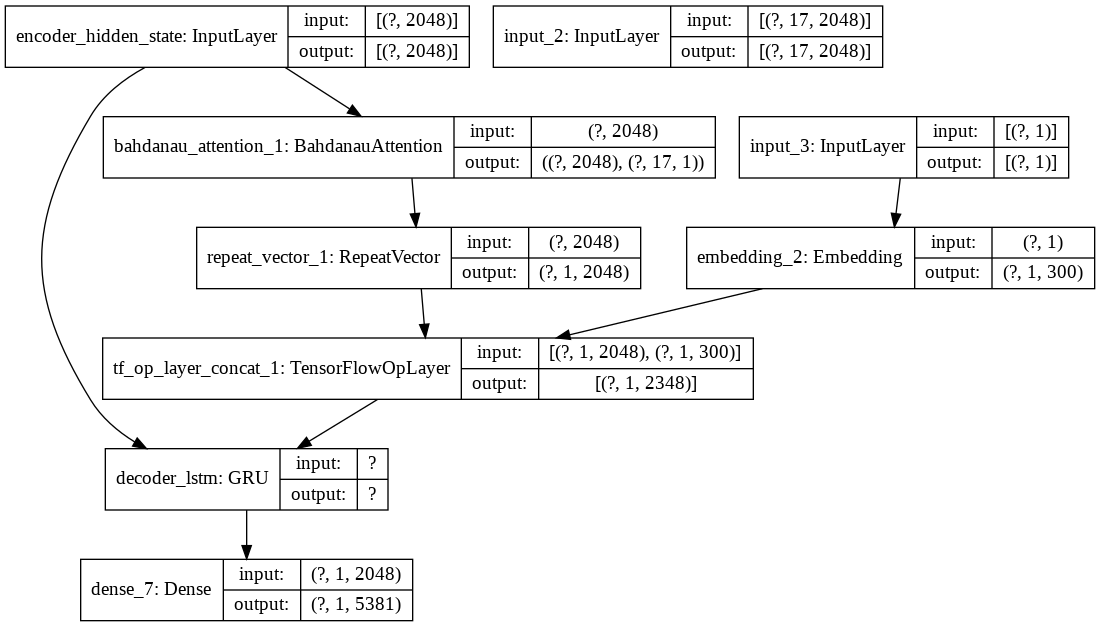

In [ ]:
#decoder_model_inference 1
decoder_inf_state_input_h = Input(shape=(nodes_lstm*2,), name="encoder_hidden_state")
encoder_output_input = Input(shape=(global_max_len, nodes_lstm*2))
#decoder_inputs
decoder_inf_input = Input(shape=(1,))
decoder_inf_input_one = Embedding(en_vocab_size, 300,\
                        weights=[emb_en],mask_zero=True)(decoder_inf_input)

#Attention Layer
attention_layer = BahdanauAttention(nodes_lstm*2)
context_vector, attention_weights = attention_layer(decoder_inf_state_input_h, encoder_output_input)#output del encoder y decoder
context_vector = tf.keras.layers.RepeatVector(1)(context_vector)#repeat vector=longitud de secuencia objetivo 

#decoder
decoder_emb_attention = tf.concat([context_vector, decoder_inf_input_one], axis=-1)
decoder_inf_gru = GRU(nodes_lstm*2, return_sequences=True, return_state=True, unroll=True)
decoder_inf, h_inf = decoder_gru(decoder_emb_attention, initial_state=decoder_inf_state_input_h)
decoder_inf_state = h_inf

decoder_inf_output = Dense(en_vocab_size, activation="softmax")(decoder_inf)



decoder_inf_model = Model([decoder_inf_input, encoder_output_input, decoder_inf_state_input_h],\
                          [decoder_inf_output, decoder_inf_state])
decoder_inf_model.summary()

plot_model(decoder_inf_model, to_file="/content/gdrive/My Drive/tfm/decoder_inf_model_v2.png",\
           show_shapes=True, show_layer_names =True)



In [ ]:
#decoder_inf_model.save("/content/gdrive/My Drive/tfm/decoder_inf_model_v3_1.h5")
decoder_inf_model.save_weights("/content/gdrive/My Drive/tfm/decoder_inf_weights_v3_1.h5")

###2.3.4 Loop para inferencia

In [ ]:
#diccionario inverso integer-palabra
decoding_dict = {v:k for k, v in en_tokenizer_lang.word_index.items()}

In [ ]:
decode_zh = {v:k for k, v in zh_tokenizer_lang.word_index.items()}
decode_en = {v:k for k, v in en_tokenizer_lang.word_index.items()}

In [ ]:
def translate_sentence(input_sentence, target_tokenizer, decoding_dict, output_max_len):
    encoder_output, states_value = encoder_inf.predict(input_sentence)
    
    target_sequence = np.zeros((1,1))
    target_sequence[0,0]=target_tokenizer.word_index.get("start")
    end_of_sequence = target_tokenizer.word_index.get("end")

    translated_sentence = []
    
    for i in range(output_max_len):
        output_token, decoder_states = decoder_inf_model.predict([target_sequence,\
                                                                  encoder_output, states_value])
        id_word = np.argmax(output_token[0,-1,:])

        if id_word == end_of_sequence or input_sentence[0][i] == 0:#esta ultima condicion esta mal
            break

        decoded_word = ""

        if id_word > 0:
            decoded_word = decoding_dict[id_word]
            translated_sentence.append(decoded_word)
        
        target_sequence[0,0] = id_word
        states_value = decoder_states

    
    return " ".join(translated_sentence)


In [ ]:
#Prueba 
sentence = zh_train[0:1]
tr =translate_sentence(sentence, en_tokenizer_lang, decoding_dict=decoding_dict,\
                       output_max_len=global_max_len)
print(tr)

service failure nobel drunken drunken under under become


In [ ]:
def translate_corpus(corpus, tokenizer, decoding_dict, output_max_len):
    corpus_list = list()
    for i in range(0, len(corpus)):
        line = translate_sentence(corpus[i:i+1], tokenizer, decoding_dict, output_max_len)
        corpus_list.append(line)
    return corpus_list

###2.3.5 Evaluación modelo

In [ ]:
decode_zh = {v:k for k, v in zh_tokenizer_lang.word_index.items()}
decode_en = {v:k for k, v in en_tokenizer_lang.word_index.items()}

decode_zh.update({0:"0"})
decode_en.update({0:"0"})

def decode_source(sentence):
    sent = np.ndarray.tolist(sentence)
    words = [decode_zh.get(letter) for letter in sent]
    my_texts = (["".join(words[i]) for i in range(len(words))])
    texto = [i for i in my_texts if i!="0"]
    return texto    

def decode_target(sentence):
    sent = np.ndarray.tolist(sentence)
    words = [decode_en.get(letter) for letter in sent]
    my_texts = (["".join(words[i]) for i in range(len(words))])
    texto = [i for i in my_texts if i!="0"]
    return texto


In [ ]:
#tokenizer = en_tokenizer_lang
#output_max_len = global_max_len
#decoding_dict = decode_zh
def evaluar_modelo(source_corpus, target_corpus):
    original = source_corpus #formato: lista de frases que son listas de token
    actual = [decode_target(target_corpus[i]) for i in range(len(target_corpus))] #formato: lista de frases que son listas de tokens
    predicted = translate_corpus(source_corpus, en_tokenizer_lang,\
                                 decoding_dict=decode_en, output_max_len=global_max_len)
    
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
c = zh_test[0:1000]
p = en_test[0:1000]
evaluacion = evaluar_modelo(c, p)

BLEU-1: 0.283119
BLEU-2: 0.151314
BLEU-3: 0.078178
BLEU-4: 0.023579


In [ ]:
a = zh_train[0:1000]
b = en_train[0:1000]
evaluacion = evaluar_modelo(a, b)

BLEU-1: 0.279660
BLEU-2: 0.152872
BLEU-3: 0.083379
BLEU-4: 0.026288


#3) OCR texto en chino

In [ ]:
! apt install tesseract-ocr
! apt install libtesseract-dev

In [ ]:
pip install pytesseract

In [ ]:
import shutil

In [ ]:
#Archivos preentrenados de chino tradicional y simplificado para tesseract
zh_sim_file = "/content/gdrive/My Drive/tfm/chi_sim_vert.traineddata"
zh_tra_file = "/content/gdrive/My Drive/tfm/chi_tra_vert.traineddata"
shutil.copy(zh_sim_file, "/usr/share/tesseract-ocr/4.00/tessdata")
shutil.copy(zh_tra_file, "/usr/share/tesseract-ocr/4.00/tessdata")

##3.1 Importar imagen como string

In [ ]:
from PIL import Image
from pytesseract import image_to_string

La imagen se importa con cada caracter separado. Esto dificulta la tokenizacion

Preprocesado:
1)Eliminar todos los espacios
2)Aplicar funcion inicial de preprocesado para separar por frases y tokenizar por palabras

In [ ]:
#Funciones de pre procesado
def from_image_to_text(image):
    im = Image.open(image)
    text_im = image_to_string((im), lang='chi_sim_vert+chi_tra_vert')

    text = re.sub(" ", "", text_im) #Eliminamos espacios para poder aplicar nuestro preprocesado
    return text

##3.2 Traducir contenido de la imagen

In [ ]:
def translate_image(image_data, decoding_dictionary, max_features=1000):

    max_len_str = max_len(image_data)
    tokenizer_lang, word_matrix = tokenizer(image_data, max_len=max_len_str, max_features=max_features)

    image_translation = translate_corpus(word_matrix, tokenizer_lang,\
                        decoding_dictionary, output_max_len=max_len_str )

    return image_translation

In [ ]:
imagen_prueba = "/content/gdrive/My Drive/tfm/img_prueba.png"

In [ ]:
#Prueba
texto_imagen = from_image_to_text(imagen_prueba)
traducción = translate_image(texto_imagen, decode_en)